# Import các thư viện

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import os
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.offline as pyo
import seaborn as sns
import matplotlib.pyplot as plt

# Chuẩn bị dữ liệu

In [53]:
data = pd.read_csv('/content/drive/MyDrive/Predicting Stock Market Trends/VCB-History.csv')

In [54]:
data.head(10)

Unnamed: 0        time   open   high    low  close  volume ticker
0           0  2019-05-20  43070  43910  43010  43710  607060    VCB
1           1  2019-05-21  43780  44100  43650  43650  473170    VCB
2           2  2019-05-22  43330  44230  43200  43330  662700    VCB
3           3  2019-05-23  43460  43840  43260  43590  378440    VCB
4           4  2019-05-24  43390  43840  42620  42880  931250    VCB
5           5  2019-05-27  43200  43710  42880  43460  341320    VCB
6           6  2019-05-28  43200  44230  43070  43460  664400    VCB
7           7  2019-05-29  43590  43910  43330  43520  313510    VCB
8           8  2019-05-30  43520  43910  43390  43650  320900    VCB
9           9  2019-05-31  43520  43840  43070  43330  712090    VCB

# Tiền xử lý
**Loại bỏ những cột không cần thiết**

In [55]:
data= data.drop(columns=['Unnamed: 0'])
data = data.drop(columns=['ticker'])
data['time'] = pd.to_datetime(data['time'])

In [56]:
# Hiển thị 10 dòng đầu của VCB
data.head(10)

time   open   high    low  close  volume
0 2019-05-20  43070  43910  43010  43710  607060
1 2019-05-21  43780  44100  43650  43650  473170
2 2019-05-22  43330  44230  43200  43330  662700
3 2019-05-23  43460  43840  43260  43590  378440
4 2019-05-24  43390  43840  42620  42880  931250
5 2019-05-27  43200  43710  42880  43460  341320
6 2019-05-28  43200  44230  43070  43460  664400
7 2019-05-29  43590  43910  43330  43520  313510
8 2019-05-30  43520  43910  43390  43650  320900
9 2019-05-31  43520  43840  43070  43330  712090

**Giải thích ý nghĩa tên các cột:**
- time: Ngày giao dịch. Đây là cột chỉ ra ngày cụ thể mà các giao dịch này đã diễn ra, theo định dạng năm-tháng-ngày (YYYY-MM-DD).
- open: Giá mở cửa. Đây là mức giá đầu tiên được giao dịch vào ngày đó.
- high: Giá cao nhất. Đây là mức giá cao nhất mà cổ phiếu được giao dịch trong ngày.
- low: Giá thấp nhất. Đây là mức giá thấp nhất mà cổ phiếu được giao dịch trong ngày.
- close: Giá đóng cửa. Đây là mức giá cuối cùng được giao dịch vào ngày đó.
- volume: Khối lượng giao dịch. Đây là tổng số lượng cổ phiếu được giao dịch trong ngày.


# Thêm 10 chỉ số vào bộ dữ liệu

> Thêm khối trích dẫn



In [57]:
import pandas as pd
import numpy as np

data['time'] = pd.to_datetime(data['time'])

# Tính các chỉ số kỹ thuật
# SMA (Simple Moving Average)
data['SMA_10'] = data['close'].rolling(window=10).mean()

# EMA (Exponential Moving Average)
data['EMA_10'] = data['close'].ewm(span=10, adjust=False).mean()

# RSI (Relative Strength Index)
def calculate_rsi(data, window=14):
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data['RSI_14'] = calculate_rsi(data, window=14)

# MACD (Moving Average Convergence Divergence)
ema_12 = data['close'].ewm(span=12, adjust=False).mean()
ema_26 = data['close'].ewm(span=26, adjust=False).mean()
data['MACD'] = ema_12 - ema_26
data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

# Bollinger Bands
data['Bollinger_Upper'] = data['SMA_10'] + (data['close'].rolling(window=10).std() * 2)
data['Bollinger_Lower'] = data['SMA_10'] - (data['close'].rolling(window=10).std() * 2)

# ATR (Average True Range)
def calculate_atr(data, window=14):
    high_low = data['high'] - data['low']
    high_close = (data['high'] - data['close'].shift()).abs()
    low_close = (data['low'] - data['close'].shift()).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return tr.rolling(window=window).mean()

data['ATR_14'] = calculate_atr(data, window=14)

# Stochastic Oscillator
def stochastic_oscillator(data, k_window=14, d_window=3):
    min_low = data['low'].rolling(window=k_window).min()
    max_high = data['high'].rolling(window=k_window).max()
    k = 100 * ((data['close'] - min_low) / (max_high - min_low))
    d = k.rolling(window=d_window).mean()
    return k, d

data['Stoch_K'], data['Stoch_D'] = stochastic_oscillator(data)

# ADX (Average Directional Index)
def calculate_adx(data, window=14):
    high = data['high']
    low = data['low']
    close = data['close']

    up_move = high.diff()
    down_move = low.diff().abs()

    tr = calculate_atr(data, window)

    plus_di = 100 * (up_move.rolling(window).mean() / tr)
    minus_di = 100 * (down_move.rolling(window).mean() / tr)

    adx = (plus_di - minus_di).abs().rolling(window).mean()
    return adx

data['ADX_14'] = calculate_adx(data)

# Volume Moving Average
data['Volume_SMA_10'] = data['volume'].rolling(window=10).mean()

# CCI (Commodity Channel Index)
def calculate_cci(data, window=20):
    typical_price = (data['high'] + data['low'] + data['close']) / 3
    sma = typical_price.rolling(window=window).mean()
    mad = (typical_price - sma).abs().rolling(window=window).mean()
    cci = (typical_price - sma) / (0.015 * mad)
    return cci

data['CCI_20'] = calculate_cci(data)

In [58]:
data

time   open   high    low  close   volume   SMA_10        EMA_10  \
0    2019-05-20  43070  43910  43010  43710   607060      NaN  43710.000000   
1    2019-05-21  43780  44100  43650  43650   473170      NaN  43699.090909   
2    2019-05-22  43330  44230  43200  43330   662700      NaN  43631.983471   
3    2019-05-23  43460  43840  43260  43590   378440      NaN  43624.350113   
4    2019-05-24  43390  43840  42620  42880   931250      NaN  43489.013729   
...         ...    ...    ...    ...    ...      ...      ...           ...   
1248 2024-05-14  91100  91600  90500  90600   818400  92060.0  91769.313596   
1249 2024-05-15  91000  91300  90800  91000   883100  92040.0  91629.438397   
1250 2024-05-16  92000  92700  91500  92600  1713900  92110.0  91805.904143   
1251 2024-05-17  92600  92600  91700  91800  1084700  92040.0  91804.830662   
1252 2024-05-20  92300  93000  91800  91900  1043800  91930.0  91822.134178   

         RSI_14        MACD  MACD_Signal  Bollinger_Upper  Bollinger_Lower  \
0           NaN    0.000000     0.000000              NaN              NaN   
1           NaN   -4.786325    -0.957265              NaN              NaN   
2           NaN  -34.008815    -7.567575              NaN              NaN   
3           NaN  -35.775623   -13.209184              NaN              NaN   
4           NaN  -93.390351   -29.245418              NaN              NaN   
...         ...         ...          ...              ...              ...   
1248  50.819672 -494.823047  -484.021539     93809.158528     90310.841472   
1249  53.125000 -525.380310  -492.293293     93836.787256     90243.212744   
1250  66.666667 -415.698618  -476.974358     93936.836975     90283.163025   
1251  57.692308 -388.846025  -459.348691     93854.019478     90225.980522   
1252  56.000000 -355.399168  -438.558787     93614.042755     90245.957245   

           ATR_14    Stoch_K    Stoch_D     ADX_14  Volume_SMA_10     CCI_20  
0             NaN        NaN        NaN        NaN            NaN        NaN  
1             NaN        NaN        NaN        NaN            NaN        NaN  
2             NaN        NaN        NaN        NaN            NaN        NaN  
3             NaN        NaN        NaN        NaN            NaN        NaN  
4             NaN        NaN        NaN        NaN            NaN        NaN  
...           ...        ...        ...        ...            ...        ...  
1248  1435.714286  28.571429  40.816327  44.985579      1112980.0 -47.674790  
1249  1400.000000  36.734694  34.013605  44.380504      1031460.0 -35.521591  
1250  1378.571429  62.500000  42.602041  43.328644      1109610.0  21.628432  
1251  1371.428571  36.111111  45.115268  41.887711      1071010.0  15.372957  
1252  1285.714286  38.888889  45.833333  41.270152      1060670.0  25.024024  

[1253 rows x 19 columns]

In [59]:
print(data.isnull().sum())

time                0
open                0
high                0
low                 0
close               0
volume              0
SMA_10              9
EMA_10              0
RSI_14             13
MACD                0
MACD_Signal         0
Bollinger_Upper     9
Bollinger_Lower     9
ATR_14             13
Stoch_K            13
Stoch_D            15
ADX_14             27
Volume_SMA_10       9
CCI_20             38
dtype: int64


## EDA (Khám phá dữ liệu)

> Ta thấy dữ liệu chỉ có thông tin 5 ngày/tuần(T2-T6) vì sàn giao dịch chứng khoán quy định ngày giao dịch từ thứ 2 đến thứ 6 trừ thứ 7, CN và Lễ theo quy định chung

In [60]:
# Kiểm tra xem lễ 30/4 có dữ liệu không
date = '30-4-2019'
test = data.loc[data['time'] ==  date]
test

Empty DataFrame
Columns: [time, open, high, low, close, volume, SMA_10, EMA_10, RSI_14, MACD, MACD_Signal, Bollinger_Upper, Bollinger_Lower, ATR_14, Stoch_K, Stoch_D, ADX_14, Volume_SMA_10, CCI_20]
Index: []

Không có dữ liệu chứng tỏ sàn giao dịch không làm việc vào ngày lễ

##Thống kê mô tả dữ liệu
- .describe() dùng để xem các thống kê mô tả. Thống kê mô tả bao gồm các thống kê tóm tắt về số lượng mẫu, trung bình, độ lệch chuẩn và hình dạng của phân phối dữ liệu.

In [61]:
data.describe().T

count                           mean                  min  \
time               1253  2021-11-13 07:09:48.986432512  2019-05-20 00:00:00   
open             1253.0                   66974.542698              37210.0   
high             1253.0                    67729.00399              37990.0   
low              1253.0                   66229.066241              36820.0   
close            1253.0                   67016.932163              37210.0   
volume           1253.0                 1147215.219473             113900.0   
SMA_10           1244.0                   67012.758039              40299.0   
EMA_10           1253.0                   66844.143173         41457.158547   
RSI_14           1240.0                      52.677697             4.868914   
MACD             1253.0                     272.488199         -4559.053738   
MACD_Signal      1253.0                     273.888227         -3906.160963   
Bollinger_Upper  1244.0                   69551.177478         43820.370282   
Bollinger_Lower  1244.0                   64474.338599         35224.628377   
ATR_14           1240.0                    1574.439171           602.857143   
Stoch_K          1240.0                      54.531125                  0.0   
Stoch_D          1238.0                      54.556826             0.414723   
ADX_14           1226.0                      43.596965             5.849498   
Volume_SMA_10    1244.0                 1149531.037781             401880.0   
CCI_20           1215.0                       9.794502          -316.846311   

                                 25%                  50%  \
time             2020-08-13 00:00:00  2021-11-11 00:00:00   
open                         56530.0              64930.0   
high                         57060.0              65489.0   
low                          55840.0              64010.0   
close                        56530.0              64930.0   
volume                      725310.0            1025700.0   
SMA_10                       56605.0              64901.8   
EMA_10                  56411.016359         64870.668498   
RSI_14                     41.784837            52.550984   
MACD                      -407.89617           182.461876   
MACD_Signal              -360.007231           219.235533   
Bollinger_Upper         59121.784796         67683.271682   
Bollinger_Lower          54140.38981         62419.193153   
ATR_14                   1147.142857          1464.285714   
Stoch_K                    32.033991            54.545455   
Stoch_D                    32.641209            54.070592   
ADX_14                     30.394768            43.328714   
Volume_SMA_10               854650.5            1062486.5   
CCI_20                    -46.592468            10.582612   

                                 75%                  max            std  
time             2023-02-15 00:00:00  2024-05-20 00:00:00            NaN  
open                         76210.0              98500.0      13513.585  
high                         77140.0             100500.0   13562.754813  
low                          75360.0              97300.0   13415.150301  
close                        76210.0              97400.0   13487.722706  
volume                     1433230.0            6274200.0  628084.386881  
SMA_10                      76007.25              95850.0   13308.748645  
EMA_10                   75852.87399         95272.059595   13373.341099  
RSI_14                     64.415312            98.694779      16.673409  
MACD                       972.82909          3430.213821    1104.007739  
MACD_Signal               948.068602          2833.053261    1025.098524  
Bollinger_Upper         79544.138096        101043.837268    13481.24335  
Bollinger_Lower         73144.273098         93775.242549   13284.972196  
ATR_14                   1908.392857          3421.571429     551.589118  
Stoch_K                    80.147395                100.0      28.807316  
Stoch_D         

**Thông tin về dữ liệu**
- Phương thức .info() in ra thông tin về một DataFrame bao gồm kiểu dữ liệu và các cột, số lượng giá trị không bị thiếu.

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time             1253 non-null   datetime64[ns]
 1   open             1253 non-null   int64         
 2   high             1253 non-null   int64         
 3   low              1253 non-null   int64         
 4   close            1253 non-null   int64         
 5   volume           1253 non-null   int64         
 6   SMA_10           1244 non-null   float64       
 7   EMA_10           1253 non-null   float64       
 8   RSI_14           1240 non-null   float64       
 9   MACD             1253 non-null   float64       
 10  MACD_Signal      1253 non-null   float64       
 11  Bollinger_Upper  1244 non-null   float64       
 12  Bollinger_Lower  1244 non-null   float64       
 13  ATR_14           1240 non-null   float64       
 14  Stoch_K          1240 non-null   float64

## Data visualization

In [63]:
df = data.copy()
df.set_index('time',inplace=True)
df = df.dropna()
df

open   high    low  close   volume   SMA_10        EMA_10  \
time                                                                     
2019-07-11  46810  48100  46810  47710  1286980  46212.0  46385.893430   
2019-07-12  47710  48030  47450  47520   926210  46418.0  46592.094624   
2019-07-15  47710  48360  47520  48360  1089930  46657.0  46913.531965   
2019-07-16  48680  50290  48610  49780  1901200  47089.0  47434.707972   
2019-07-17  49320  49710  48870  49130   802350  47514.0  47742.942886   
...           ...    ...    ...    ...      ...      ...           ...   
2024-05-14  91100  91600  90500  90600   818400  92060.0  91769.313596   
2024-05-15  91000  91300  90800  91000   883100  92040.0  91629.438397   
2024-05-16  92000  92700  91500  92600  1713900  92110.0  91805.904143   
2024-05-17  92600  92600  91700  91800  1084700  92040.0  91804.830662   
2024-05-20  92300  93000  91800  91900  1043800  91930.0  91822.134178   

               RSI_14         MACD  MACD_Signal  Bollinger_Upper  \
time                                                               
2019-07-11  59.359845   740.204621   630.618513     47875.297929   
2019-07-12  52.442997   786.704535   661.835717     48174.987321   
2019-07-15  58.695652   881.179344   705.704443     48759.401801   
2019-07-16  71.906694  1058.432493   776.250053     49788.735790   
2019-07-17  71.906694  1133.392281   847.678498     49997.638907   
...               ...          ...          ...              ...   
2024-05-14  50.819672  -494.823047  -484.021539     93809.158528   
2024-05-15  53.125000  -525.380310  -492.293293     93836.787256   
2024-05-16  66.666667  -415.698618  -476.974358     93936.836975   
2024-05-17  57.692308  -388.846025  -459.348691     93854.019478   
2024-05-20  56.000000  -355.399168  -438.558787     93614.042755   

            Bollinger_Lower       ATR_14     Stoch_K    Stoch_D     ADX_14  \
time                                                                         
2019-07-11     44548.702071  1117.857143   90.250000  77.113985  40.715806   
2019-07-12     44661.012679  1030.714286   85.500000  83.966475  43.746996   
2019-07-15     44554.598199  1044.285714  100.000000  91.916667  45.598626   
2019-07-16     44389.264210  1090.000000   91.760905  92.420302  46.613793   
2019-07-17     45030.361093  1081.428571   81.260097  91.007001  46.365873   
...                     ...          ...         ...        ...        ...   
2024-05-14     90310.841472  1435.714286   28.571429  40.816327  44.985579   
2024-05-15     90243.212744  1400.000000   36.734694  34.013605  44.380504   
2024-05-16     90283.163025  1378.571429   62.500000  42.602041  43.328644   
2024-05-17     90225.980522  1371.428571   36.111111  45.115268  41.887711   
2024-05-20     90245.957245  1285.714286   38.888889  45.833333  41.270152   

            Volume_SMA_10      CCI_20  
time                                   
2019-07-11       742414.0   79.405738  
2019-07-12       752021.0   75.683198  
2019-07-15       804450.0   85.690878  
2019-07-16       958268.0  134.087651  
2019-07-17       958831.0  108.106443  
...                   ...         ...  
2024-05-14      1112980.0  -47.674790  
2024-05-15      1031460.0  -35.521591  
2024-05-16      1109610.0   21.628432  
2024-05-17      1071010.0   15.372957  
2024-05-20      1060670.0   25.024024  

[1215 rows x 18 columns]

### 1. Trực quan hóa bằng biểu đồ nến về các thuộc tính giá và khối lượng giao dịch

In [64]:

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02, row_heights=[0.7, 0.3])
candlestick = go.Candlestick(x=df.index,
                             open=df['open'],
                             high=df['high'],
                             low=df['low'],
                             close=df['close'],
                             name='Các thuộc tính giá')
fig.add_trace(candlestick, row=1, col=1)

volume = go.Bar(x=df.index, y=df['volume'], name='Khối lượng giao dịch', marker=dict(color='blue'))
fig.add_trace(volume, row=2, col=1)

fig.update_layout(title='Biểu đồ nến về các thuộc tính giá và khối lượng giao dịch',
                  yaxis_title='Giá',
                  yaxis2_title='Khối lượng giao dịch',
                  xaxis2_title='Thời gian',
                  xaxis_rangeslider_visible=False)
fig.show()

In [65]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go

fig = make_subplots(rows=5, cols=1,
                    subplot_titles=("Giá mở cửa", "Giá đóng cửa", "Giá cao nhất", "Giá thấp nhất", "Khối lượng giao dịch"))
fig.add_trace(go.Scatter(x=df.index, y=df["open"]), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df["close"]), row=2, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df["high"]), row=3, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df["low"]), row=4, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df["volume"]), row=5, col=1)
fig.update_layout(showlegend=False, height=1200, width=800)
fig.show()

### 3. Biểu đồ hiển thị mối quan hệ giữa các thuộc tính

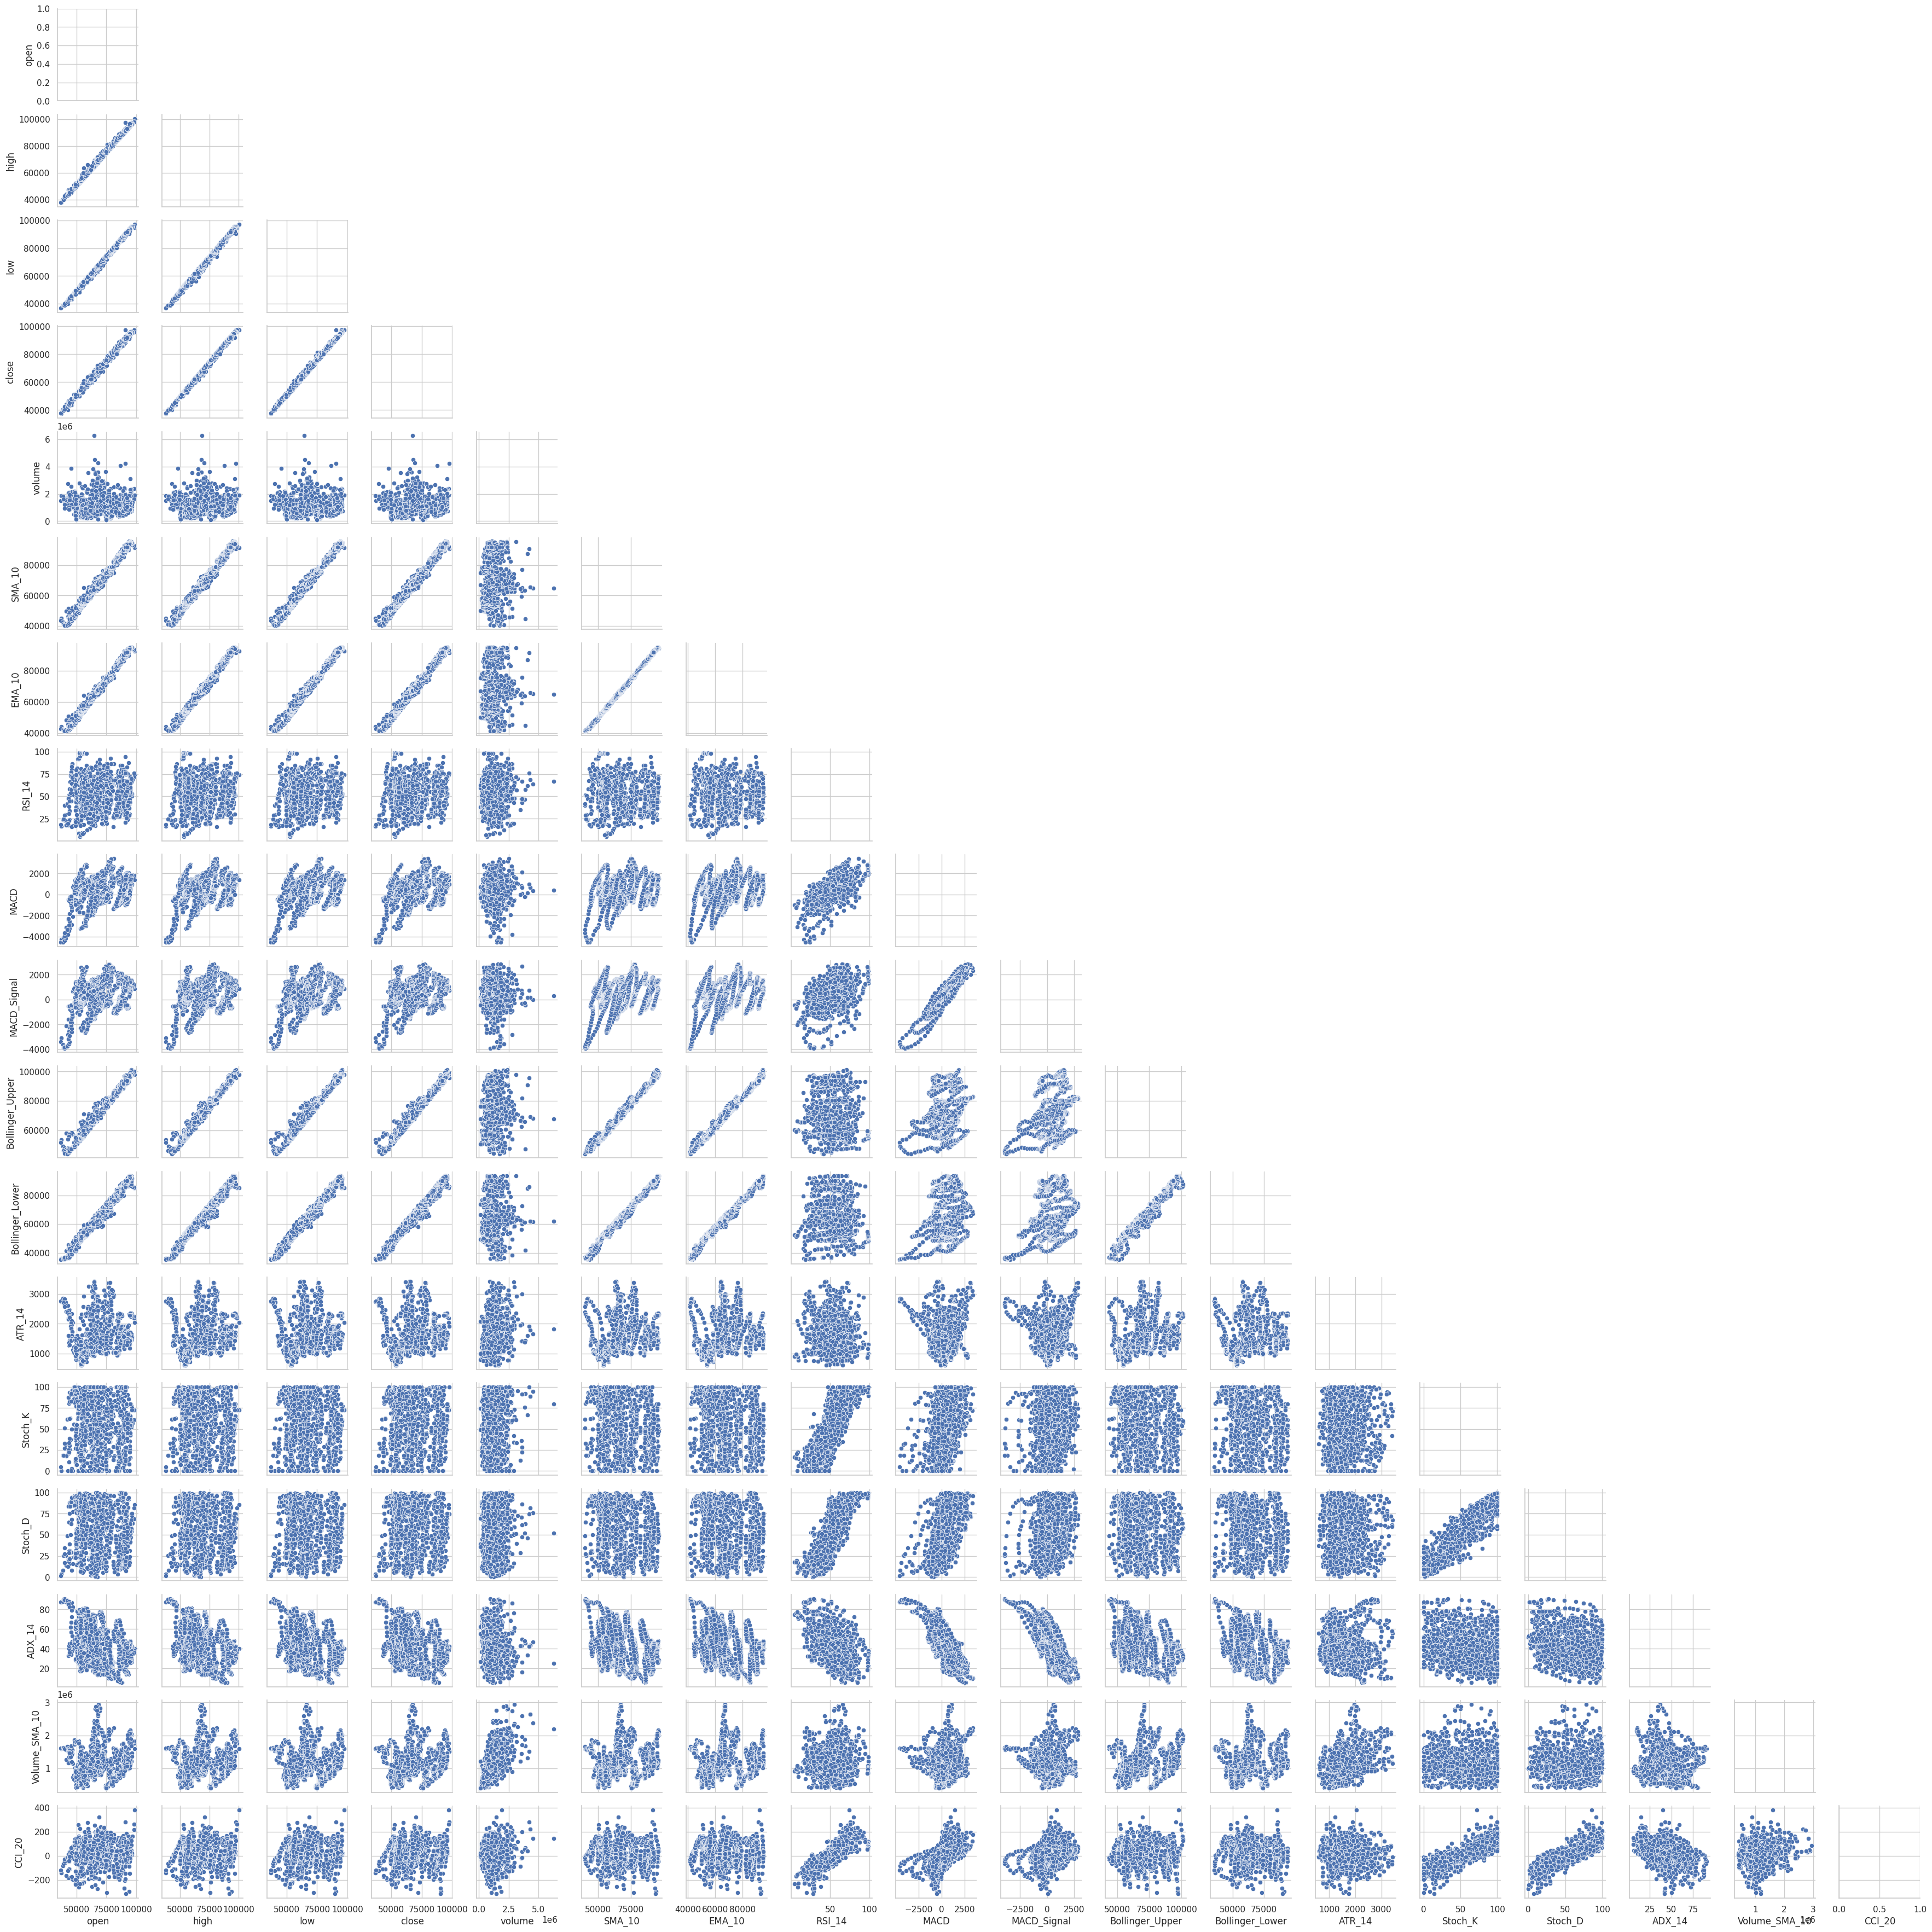

In [66]:
sns.pairplot(df, diag_kind= "reg", height = 2, aspect = 1, corner = True);

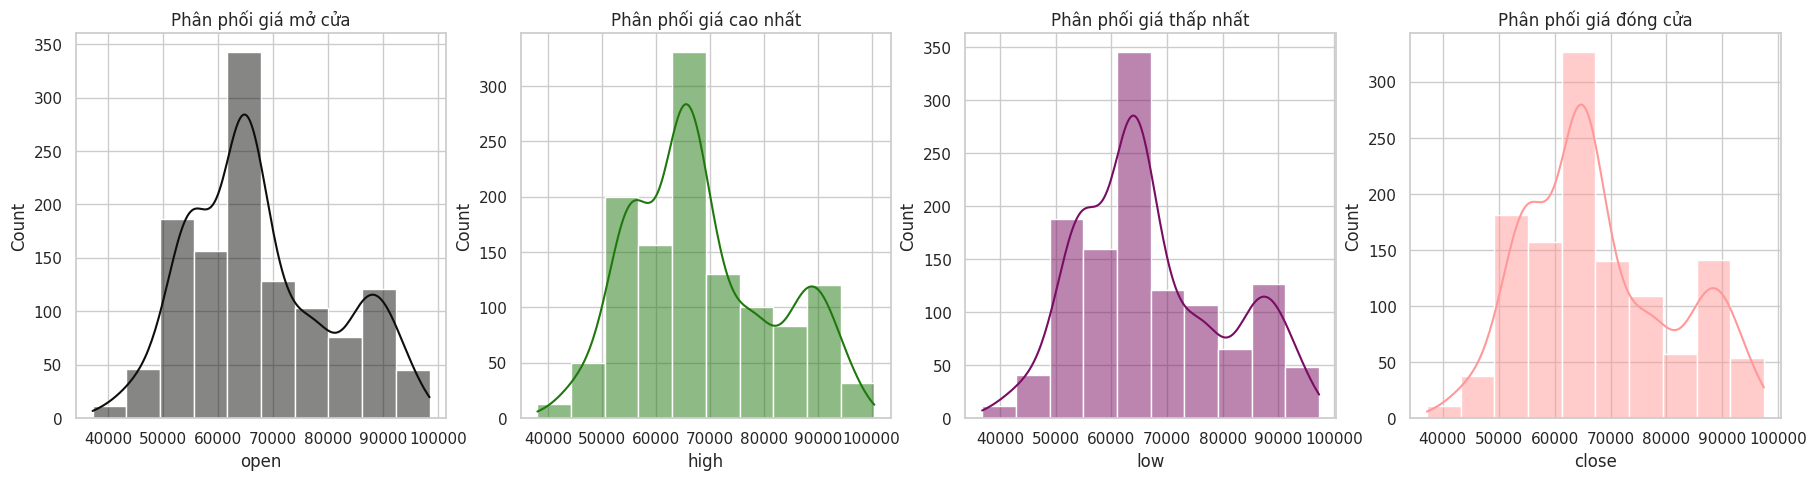

In [67]:
fig, axes = plt.subplots(1, 4, figsize=(22, 5))

sns.histplot(ax=axes[0], x=df["open"], bins=10, kde=True, color="#0E0E0D").set(title="Phân phối giá mở cửa")
sns.histplot(ax=axes[1], x=df["high"], bins=10, kde=True, color="#1F780D").set(title="Phân phối giá cao nhất")
sns.histplot(ax=axes[2], x=df["low"], bins=10, kde=True, color="#780D62").set(title="Phân phối giá thấp nhất")
sns.histplot(ax=axes[3], x=df["close"], bins=10, kde=True, color="#FF9999").set(title="Phân phối giá đóng cửa")
plt.show()


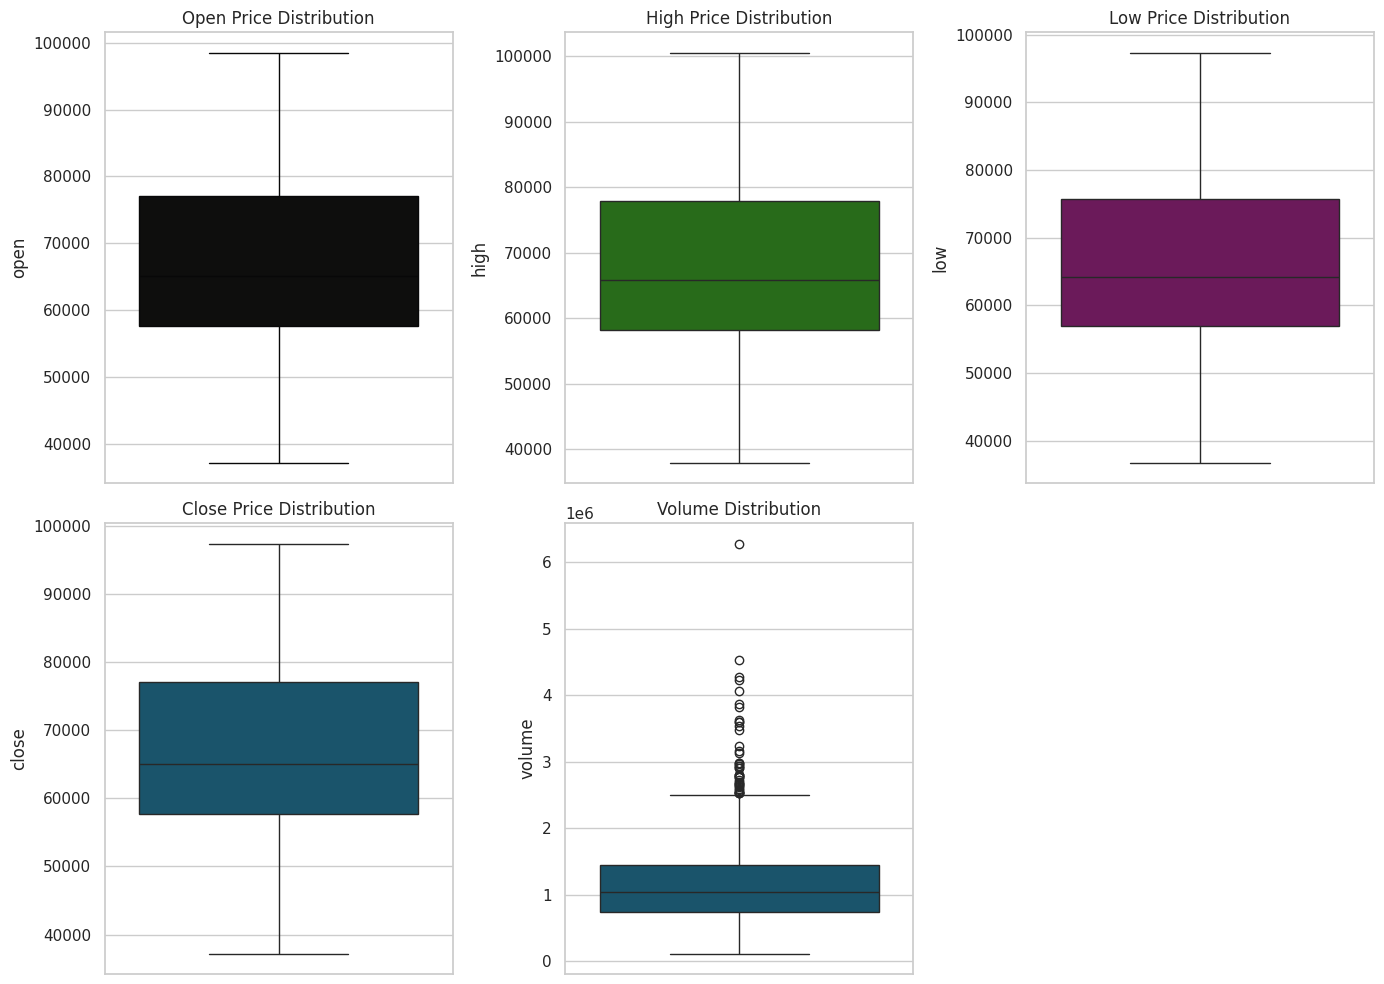

In [68]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 3, 1)
sns.boxplot(y=df["open"], color="#0E0E0D").set(title="Open Price Distribution")

plt.subplot(2, 3, 2)
sns.boxplot(y=df["high"], color="#1F780D").set(title="High Price Distribution")

plt.subplot(2, 3, 3)
sns.boxplot(y=df["low"], color="#780D62").set(title="Low Price Distribution")

plt.subplot(2, 3, 4)
sns.boxplot(y=df["close"], color="#0D5A78").set(title="Close Price Distribution")

plt.subplot(2, 3, 5)
sns.boxplot(y=df["volume"], color="#0D5A78").set(title="Volume Distribution")

plt.tight_layout()
plt.show()

3. Mối quan hệ giữa giá đóng cửa và các đường trung bình động

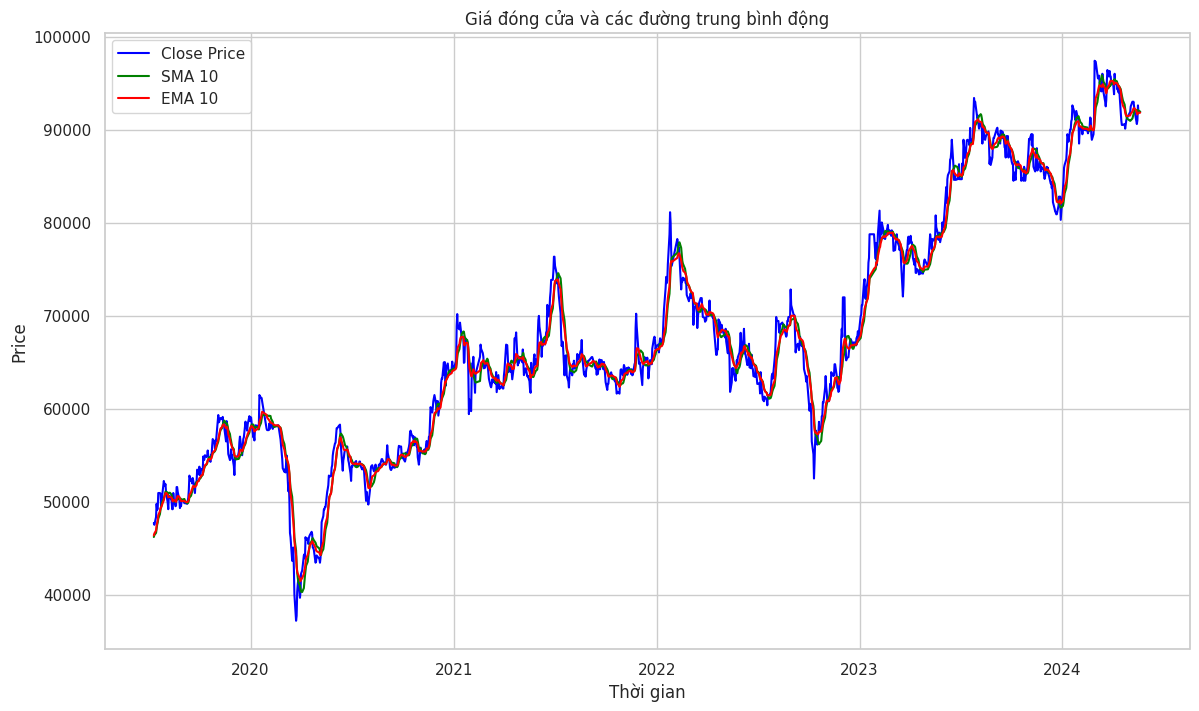

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(14, 8))
plt.plot(df.index, df['close'], label='Close Price', color='blue')
plt.plot(df.index, df['SMA_10'], label='SMA 10', color='green')
plt.plot(df.index, df['EMA_10'], label='EMA 10', color='red')
plt.xlabel('Thời gian')
plt.ylabel('Price')
plt.title('Giá đóng cửa và các đường trung bình động')
plt.legend()
plt.show()

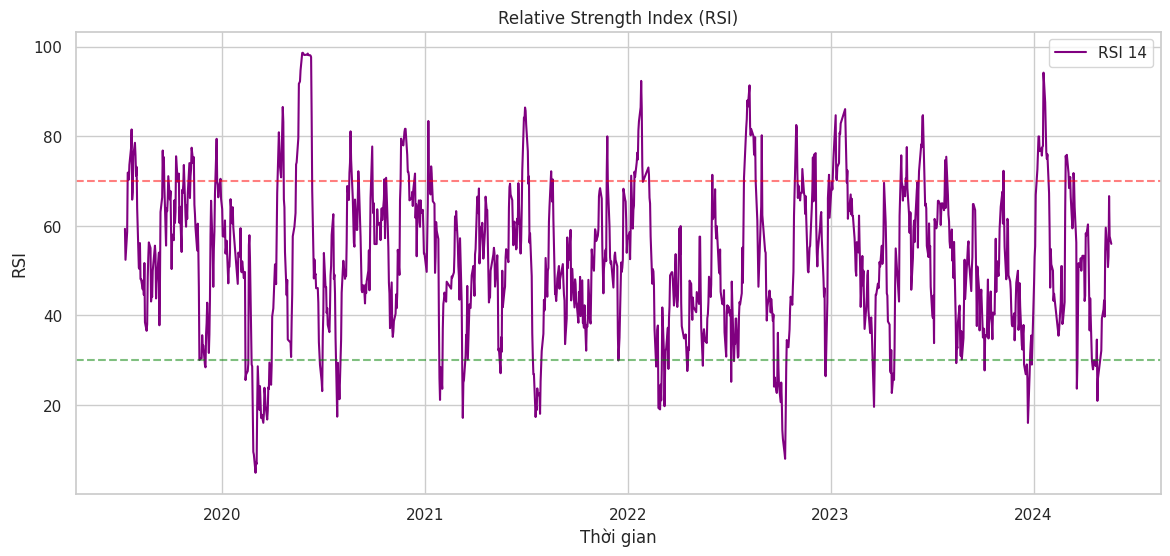

In [70]:
# Vẽ RSI
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['RSI_14'], label='RSI 14', color='purple')
plt.axhline(70, linestyle='--', alpha=0.5, color='red')
plt.axhline(30, linestyle='--', alpha=0.5, color='green')
plt.xlabel('Thời gian')
plt.ylabel('RSI')
plt.title('Relative Strength Index (RSI)')
plt.legend()
plt.show()

Vẽ biểu đồ phân tán giữa RSI và Giá Đóng Cửa

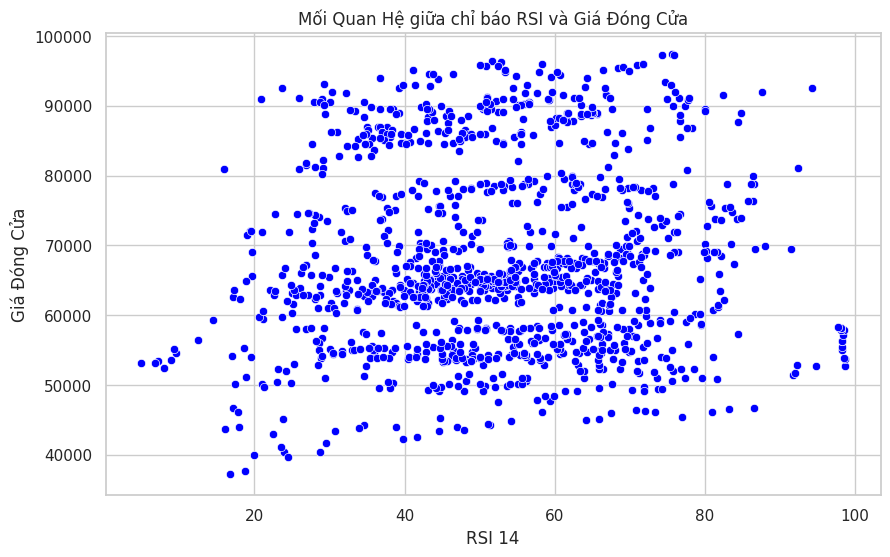

In [71]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['RSI_14'], y=df['close'], color='blue')
plt.xlabel('RSI 14')
plt.ylabel('Giá Đóng Cửa')
plt.title('Mối Quan Hệ giữa chỉ báo RSI và Giá Đóng Cửa')
plt.show()


Vẽ biểu đồ phân tán giữa MACD và Giá Đóng Cửa

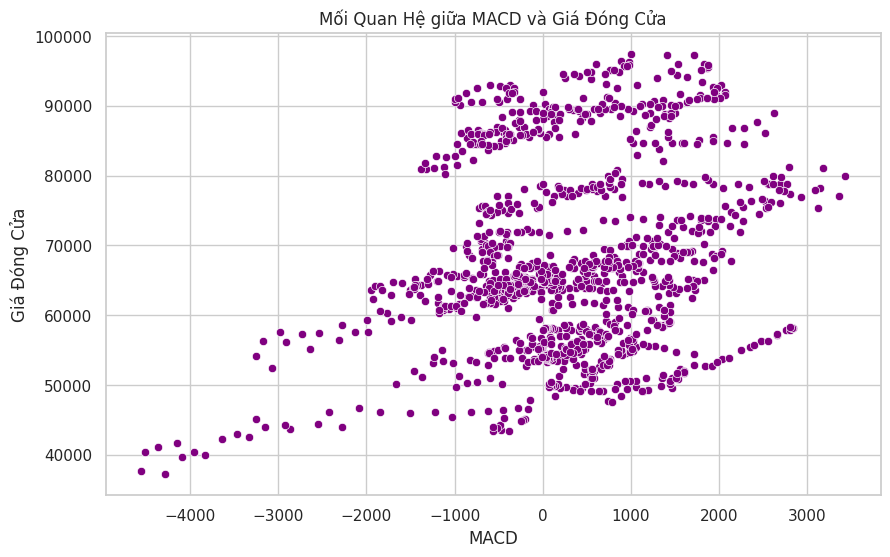

In [72]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['MACD'], y=df['close'], color='purple')
plt.xlabel('MACD')
plt.ylabel('Giá Đóng Cửa')
plt.title('Mối Quan Hệ giữa MACD và Giá Đóng Cửa')
plt.show()

Vẽ biểu đồ histogram cho RSI

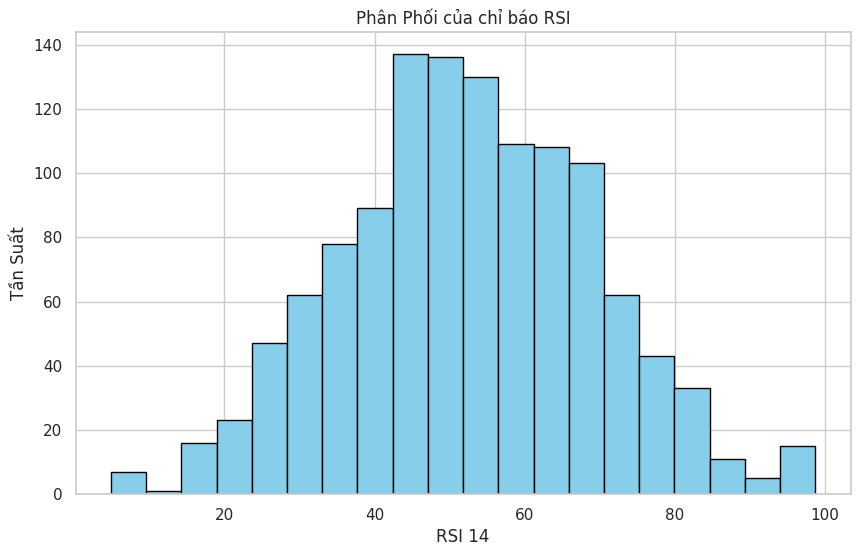

In [73]:
plt.figure(figsize=(10, 6))
plt.hist(df['RSI_14'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.xlabel('RSI 14')
plt.ylabel('Tần Suất')
plt.title('Phân Phối của chỉ báo RSI')
plt.show()

Vẽ biểu đồ histogram cho MACD

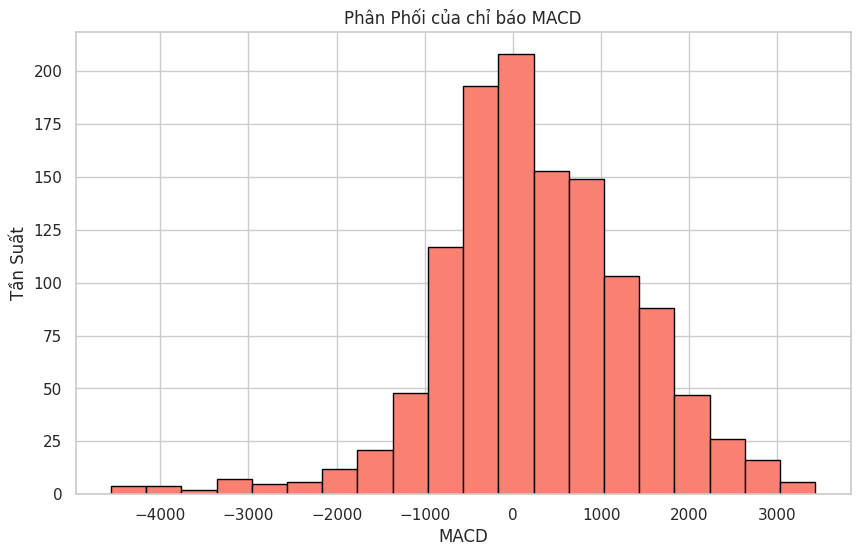

In [74]:
plt.figure(figsize=(10, 6))
plt.hist(df['MACD'].dropna(), bins=20, color='salmon', edgecolor='black')
plt.xlabel('MACD')
plt.ylabel('Tần Suất')
plt.title('Phân Phối của chỉ báo MACD')
plt.show()


**Nhận xét:**

- Trong khoảng thời gian từ 2019 đến 2024, giá có xu hướng tăng lên tổng thể. Mặc dù có những giai đoạn giá điều chỉnh và giảm, xu hướng chung là đi lên.

- Biểu đồ cho thấy nhiều giai đoạn biến động mạnh, Các giai đoạn có biến động giá mạnh ta có thể thấy như vào khoảng tháng 4/2020 giá chạm đấy,  tháng 1/2022 thì giá tăng liên tục.

- Có thể thấy rằng khối lượng giao dịch tăng mạnh ở một số thời điểm, đặc biệt là tháng 4/2021 khối lượng tăng rất mạnh.

- Điểm đảo chiều rõ ràng có thể thấy được, vào tháng 10/2020 khi giá giảm mạnh rồi sau đó tăng trở lại.

- Tình hình hiện tại giá vẫn đang trong xu hướng tăng và đạt các mức cao mới, cho thấy thị trường có thể đang trong giai đoạn tăng trưởng.

# Xây dựng và huấn luyện mô hình

##1. Decision tree
1.1 Huấn luyện mô hình

In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns

df = data.copy()
df = df.dropna()
df['Target'] = df['close'].shift(-1)

features = ['open', 'high', 'low', 'close', 'volume', 'SMA_10', 'EMA_10', 'RSI_14',
            'MACD', 'MACD_Signal', 'Bollinger_Upper', 'Bollinger_Lower', 'ATR_14',
            'Stoch_K', 'Stoch_D', 'ADX_14', 'Volume_SMA_10', 'CCI_20']
X = df[features]
y = df['Target']

df = df.dropna()
X = X.iloc[:-1]
y = y.iloc[:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(result_df.head())

print("Mean Squared Error (MSE):", round(mse,4))
print("Mean Absolute Error (MAE):", round(mae,4))
print("R² Score:", round(r2,4))


      Actual  Predicted
777  63510.0    63340.0
826  69940.0    71890.0
81   51260.0    49780.0
193  56070.0    58670.0
532  76340.0    75440.0
Mean Squared Error (MSE): 2221031.5021
Mean Absolute Error (MAE): 1048.0453
R² Score: 0.9866


1.2 Dự đoán và trực quan hoá kết quả

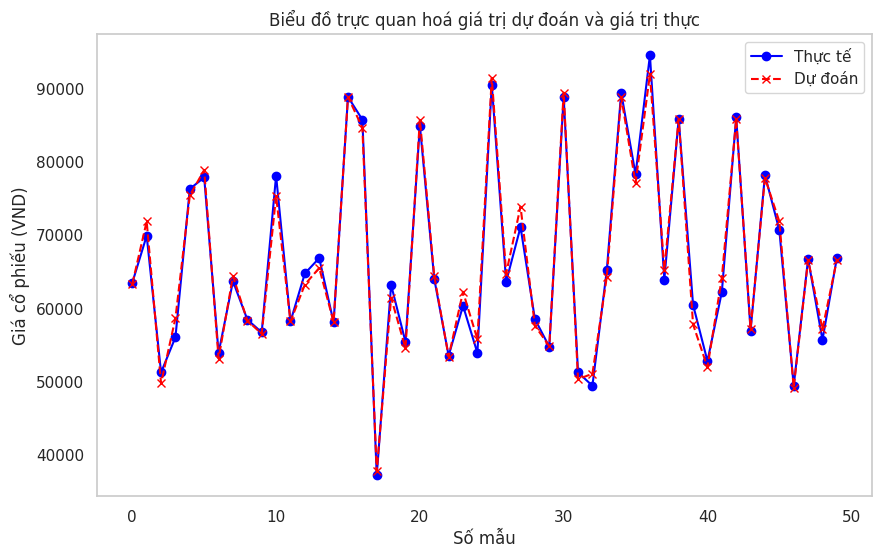

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(result_df['Actual'].values[:50], label='Thực tế', marker='o', linestyle='-', color='blue')
plt.plot(result_df['Predicted'].values[:50], label='Dự đoán', marker='x', linestyle='--', color='red')
plt.title('Biểu đồ trực quan hoá giá trị dự đoán và giá trị thực')
plt.xlabel('Số mẫu')
plt.ylabel('Giá cổ phiếu (VND)')
plt.legend()
plt.grid()
plt.show()

##2. Random forest

2.1 Xây dựng và huấn luyện mô hình

In [77]:
from sklearn.ensemble import RandomForestRegressor

df = data.copy()
df = df.dropna()

df['Target'] = df['close'].shift(-1)

features = ['open', 'high', 'low', 'close', 'volume', 'SMA_10', 'EMA_10', 'RSI_14', 'MACD',
            'MACD_Signal', 'Bollinger_Upper', 'Bollinger_Lower', 'ATR_14', 'Stoch_K',
            'Stoch_D', 'ADX_14', 'Volume_SMA_10', 'CCI_20']

X = df[features]
y = df['Target']

# Loại bỏ các hàng có giá trị NaN (do shift(-1) tạo ra)
X = X.iloc[:-1]
y = y.iloc[:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)
result_df = pd.DataFrame({'Thực tế ': y_test, 'Dự đoán': y_pred})
print(result_df.head())


     Thực tế    Dự đoán
777   63510.0  64109.24
826   69940.0  72092.90
81    51260.0  50275.70
193   56070.0  56840.00
532   76340.0  76454.50


2.2 In ra các độ đo đánh giá

In [78]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Evaluation Metrics for Random Forest Regressor:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Evaluation Metrics for Random Forest Regressor:
Mean Squared Error (MSE): 1252256.5592
Mean Absolute Error (MAE): 832.8232
R² Score: 0.9925


2.3 Trực quan hoá kết quả thu được

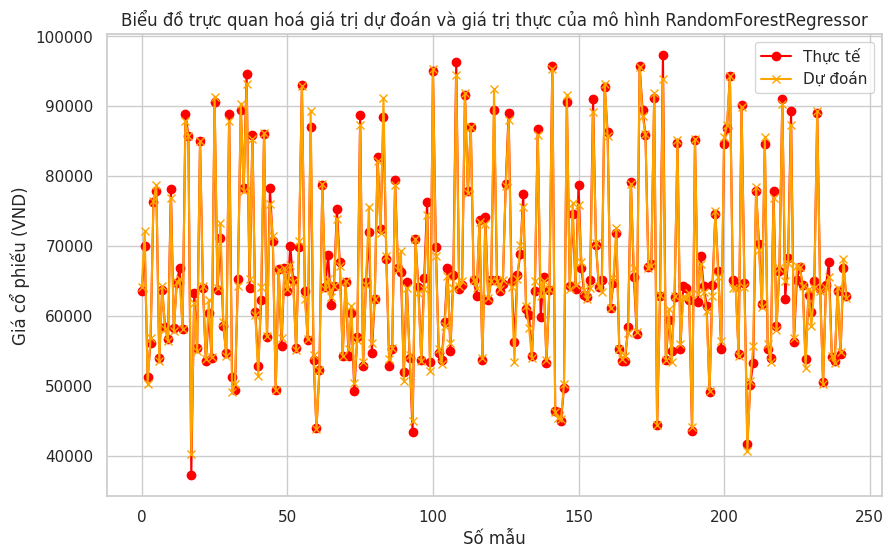

In [79]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Thực tế', marker='o', color='red')
plt.plot(y_pred, label='Dự đoán', marker='x', color='orange')
plt.title('Biểu đồ trực quan hoá giá trị dự đoán và giá trị thực của mô hình RandomForestRegressor')
plt.xlabel('Số mẫu')
plt.ylabel('Giá cổ phiếu (VND)')
plt.legend()



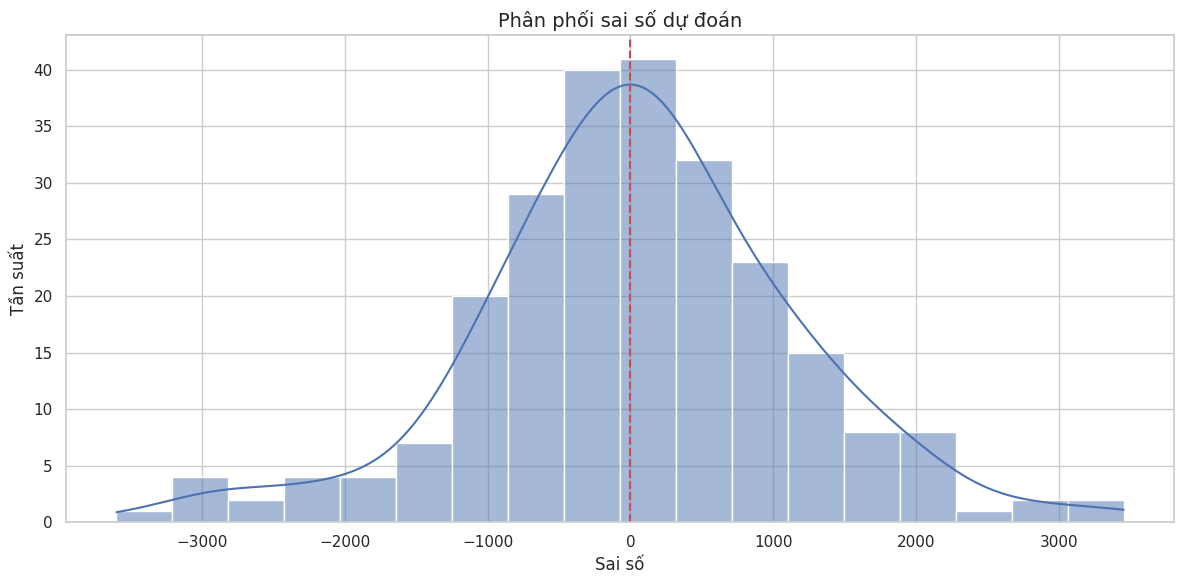

In [80]:
errors = y_test - y_pred
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.histplot(errors, kde=True)
plt.title('Phân phối sai số dự đoán', fontsize=14)
plt.xlabel('Sai số')
plt.ylabel('Tần suất')
plt.axvline(x=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

##3. ADABOOST

3.1 Xây dựng và huấn luyện mô hình

In [81]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

features = [
    'open', 'high', 'low', 'close', 'volume',
    'SMA_10', 'EMA_10', 'RSI_14',
    'MACD', 'MACD_Signal',
    'Bollinger_Upper', 'Bollinger_Lower',
    'ATR_14',
    'Stoch_K', 'Stoch_D',
    'ADX_14',
    'Volume_SMA_10',
    'CCI_20'
]

df = df.dropna()

X = df[features]
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

model_abc = AdaBoostRegressor(
    n_estimators=100,
    random_state=42,
    learning_rate=0.1
)

model_abc.fit(X_train, y_train)

y_pred = model_abc.predict(X_test)
result_df = pd.DataFrame({'Thực tế': y_test, 'Dự đoán': y_pred})
print(result_df.head())


     Thực tế       Dự đoán
777  63510.0  64410.360324
826  69940.0  71347.830189
81   51260.0  51529.808917
193  56070.0  56076.414141
532  76340.0  76352.133333


3.2 In ra các độ đo đánh giá

In [82]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\nĐánh giá mô hình AdaBoost Regressor:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")



Đánh giá mô hình AdaBoost Regressor:
Mean Squared Error (MSE): 1883960.6526
Mean Absolute Error (MAE): 1049.4828
R² Score: 0.9887


3.3 Trực quan hoá kết quả đạt được

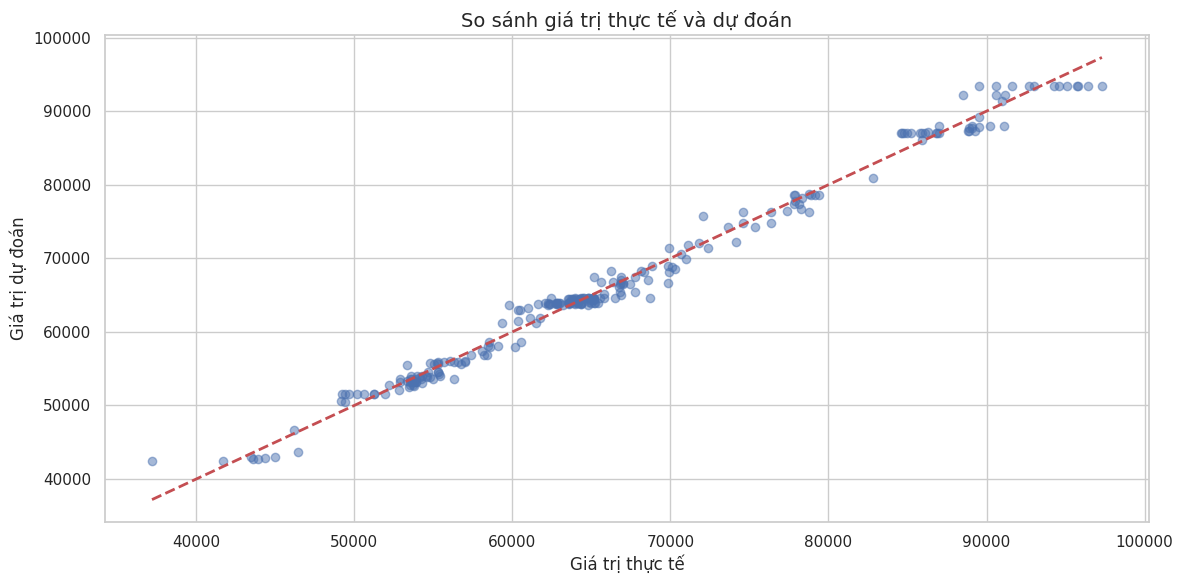

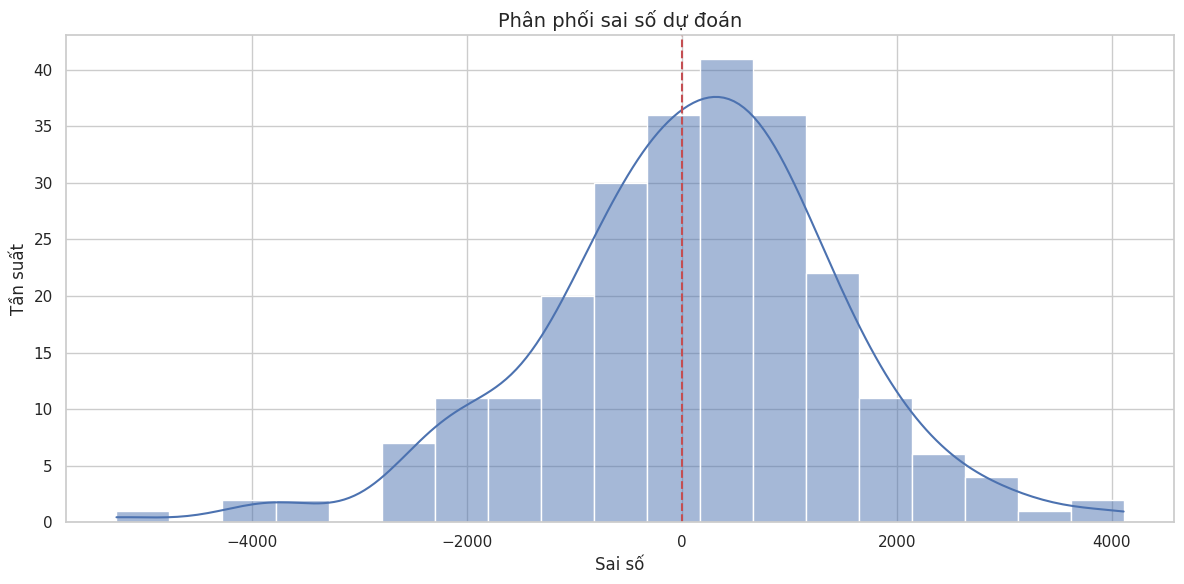

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (15, 10)

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Giá trị thực tế')
plt.ylabel('Giá trị dự đoán')
plt.title('So sánh giá trị thực tế và dự đoán', fontsize=14)
plt.tight_layout()
plt.show()

errors = y_test - y_pred
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.histplot(errors, kde=True)
plt.title('Phân phối sai số dự đoán', fontsize=14)
plt.xlabel('Sai số')
plt.ylabel('Tần suất')
plt.axvline(x=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()


Nhìn chung, biểu đồ cho thấy mô hình AdaBoost đang hoạt động khá tốt với phần lớn các dự đoán có sai số nhỏ và phân phối sai số có tính chuẩn. Tuy nhiên vẫn có không gian để cải thiện, đặc biệt là với các trường hợp có sai số lớn.

##4. XGBoost

4.1 Xây dựng và huấn luyện mô hình

In [84]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

model_xgb.fit(X_train, y_train)

y_pred_xgb = model_xgb.predict(X_test)
result_df = pd.DataFrame({'Thực tế': y_test, 'Dự đoán': y_pred_xgb})
print(result_df.head())

     Thực tế       Dự đoán
777  63510.0  63982.574219
826  69940.0  72531.882812
81   51260.0  50728.164062
193  56070.0  56289.062500
532  76340.0  76487.226562


4.2 In ra các độ đo đánh giá

In [85]:
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nĐánh giá mô hình XGBoost Regressor:")
print(f"Mean Squared Error (MSE): {mse_xgb:.4f}")
print(f"Mean Absolute Error (MAE): {mae_xgb:.4f}")
print(f"R² Score: {r2_xgb:.4f}")


Đánh giá mô hình XGBoost Regressor:
Mean Squared Error (MSE): 1178311.7357
Mean Absolute Error (MAE): 811.1399
R² Score: 0.9929


4.3 Trực quan hoá kết quả

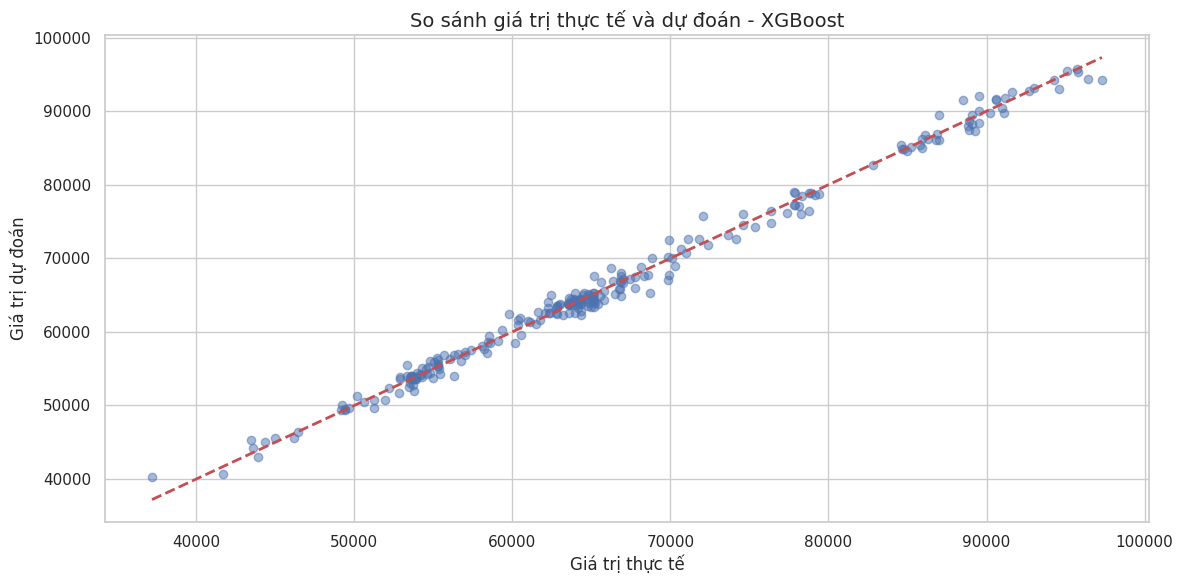

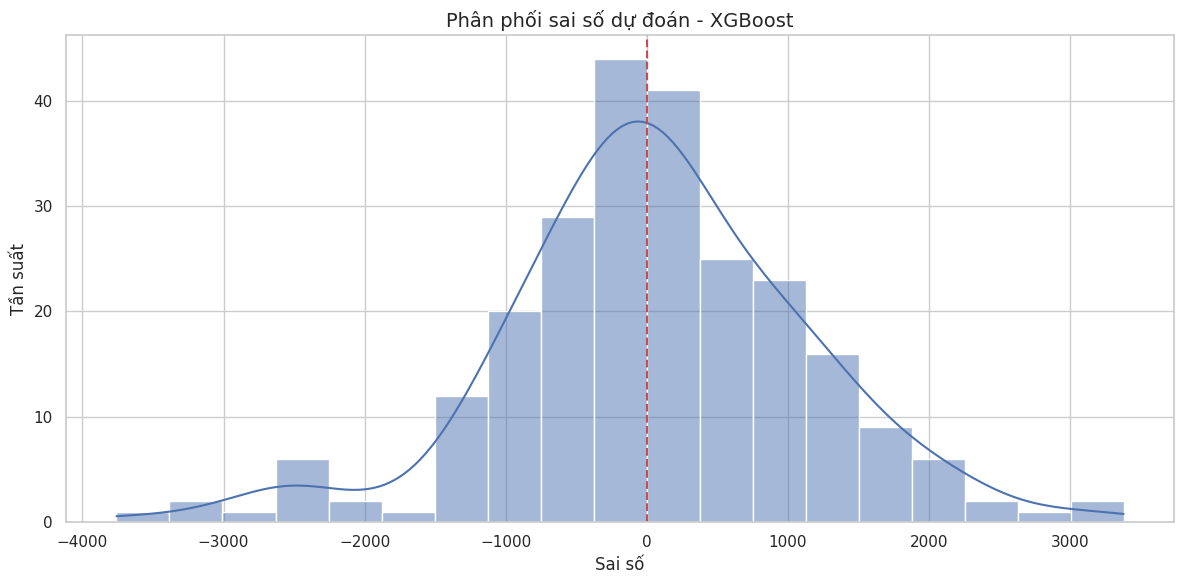

In [86]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Giá trị thực tế')
plt.ylabel('Giá trị dự đoán')
plt.title('So sánh giá trị thực tế và dự đoán - XGBoost', fontsize=14)
plt.tight_layout()
plt.show()

errors_xgb = y_test - y_pred_xgb
plt.figure(figsize=(12, 6))
sns.histplot(errors_xgb, kde=True)
plt.title('Phân phối sai số dự đoán - XGBoost', fontsize=14)
plt.xlabel('Sai số')
plt.ylabel('Tần suất')
plt.axvline(x=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

##5.SVR

5.1 Xây dựng và huấn luyện mô hình

In [87]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

features = [
    'open', 'high', 'low', 'volume',
    'SMA_10', 'EMA_10', 'RSI_14',
    'MACD', 'MACD_Signal',
    'Bollinger_Upper', 'Bollinger_Lower',
    'ATR_14',
    'Stoch_K', 'Stoch_D',
    'ADX_14',
    'Volume_SMA_10',
    'CCI_20'
]

df = df.dropna()

X = df[features]
y = df['close']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr.fit(X_train_scaled, y_train_scaled.ravel())

y_pred_scaled = svr.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

y_test = scaler_y.inverse_transform(y_test_scaled)





5.2 Các độ đo đánh giá

In [88]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)

result_df = pd.DataFrame({'Thực tế': y_test.ravel(), 'Dự đoán': y_pred.ravel()})
print(result_df.head())


Mean Squared Error (MSE): 2440370.2492112066
Mean Absolute Error (MAE): 835.4210455124464
R² Score: 0.98527336755321
   Thực tế       Dự đoán
0  64269.0  63887.062032
1  71130.0  70693.265678
2  50420.0  52830.163554
3  56720.0  57231.358723
4  76340.0  75916.242063


5.3 Trực quan hoá kết quả

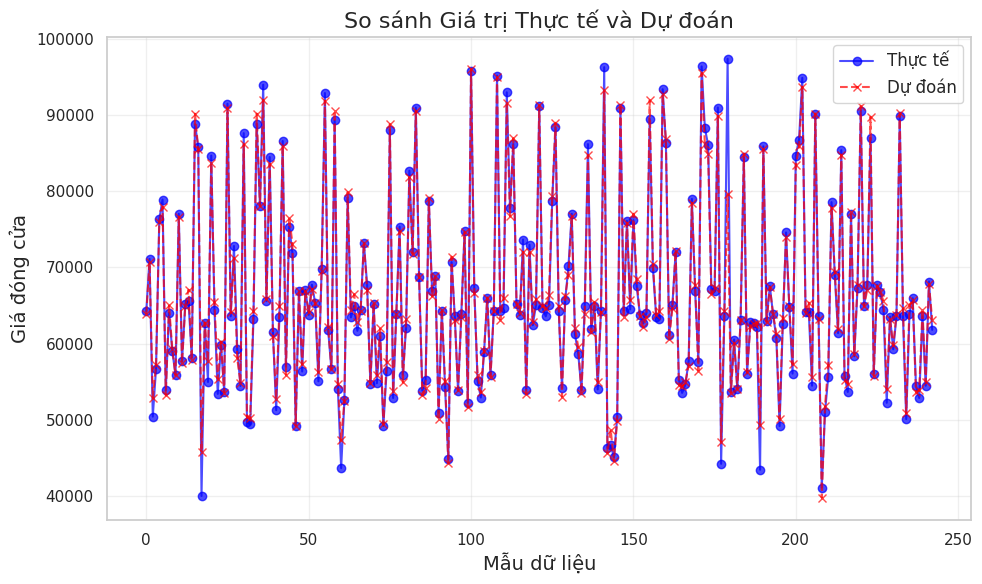

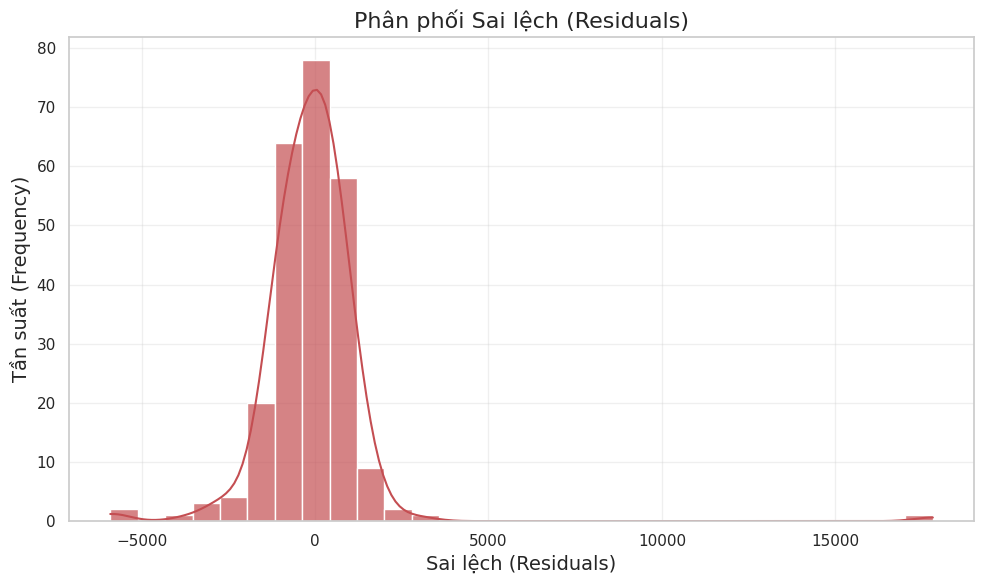

In [89]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.ravel(), label="Thực tế", color='blue', marker='o', linestyle='-', alpha=0.7)
plt.plot(y_pred.ravel(), label="Dự đoán", color='red', marker='x', linestyle='--', alpha=0.7)

plt.title("So sánh Giá trị Thực tế và Dự đoán", fontsize=16)
plt.xlabel("Mẫu dữ liệu", fontsize=14)
plt.ylabel("Giá đóng cửa", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

residuals = y_test.ravel() - y_pred.ravel()

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30, color='r', alpha=0.7)

plt.title("Phân phối Sai lệch (Residuals)", fontsize=16)
plt.xlabel("Sai lệch (Residuals)", fontsize=14)
plt.ylabel("Tần suất (Frequency)", fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()